## Sagnac Frequency - Tilt Correction

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}


config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-03-09 00:00")
config['tend'] = UTCDateTime("2024-04-08 00:00")


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [4]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [5]:
def __correct_temperature_trend(st, correction, n_shift=0, intercept=False):

    from numpy import roll

    st0 = st.copy()
    if roll == 0:
        temperature = st0.select(channel="*T")[0].data
    else:
        temperature = roll(st0.select(channel="*T")[0].data, n_shift)


    if intercept:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    else:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    plt.plot(temperature)

    return st0

## Configurations

### Load Tilt Data

  -> converted data of ROMYT


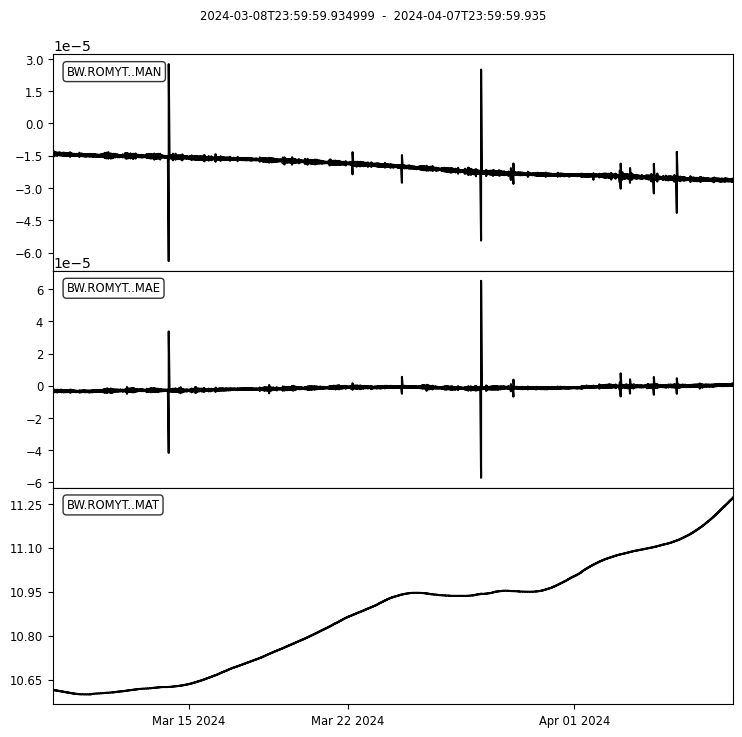

In [6]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")


# tromy0 =  __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# tromy0 = __conversion_to_tilt(tromy0, confTilt['BROMY'])


tromy0 =  __read_sds(config['path_to_sds'], "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

tromy0 = __conversion_to_tilt(tromy0, confTilt['ROMYT'])

tryom0 = tromy0.trim(config['tbeg'], config['tend'])

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

gc.collect();


### Compare Temperature and Tilt

300 300 300
Nshift:  31 Tshift:  267840.0 CC:  0.7570413108637688
Nshift:  9 Tshift:  77760.0 CC:  0.8315482098706801


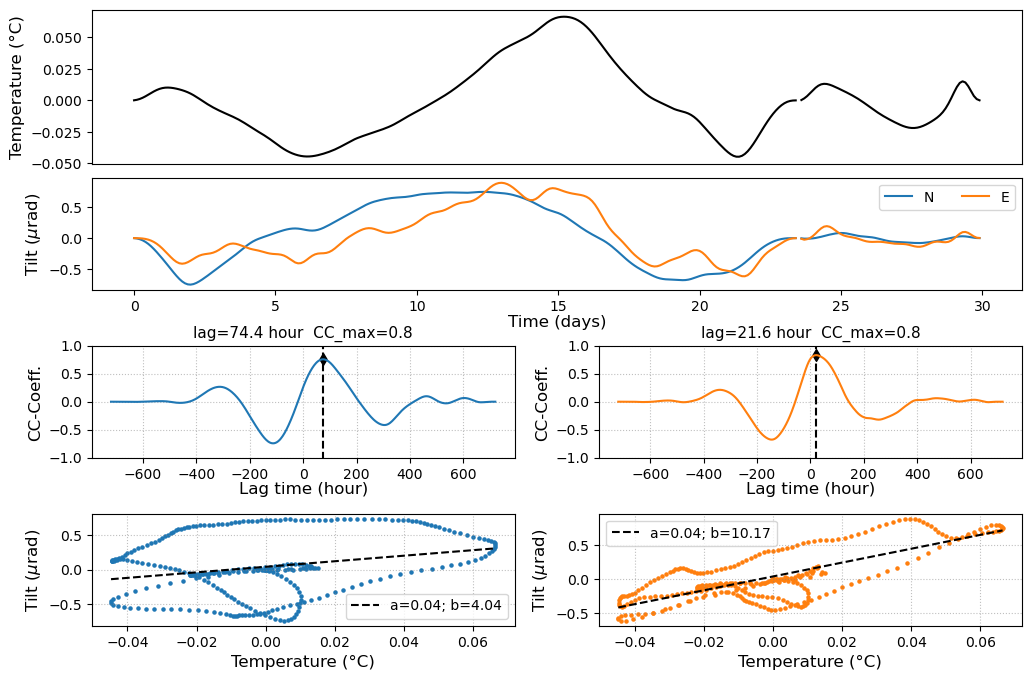

In [7]:
def __compare_tilt_temperature(st0, fmin=None, fmax=1/3600):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth


    tlp = st0.copy()

    tlp = tlp.detrend("linear")

    tlp = tlp.taper(0.1, type="cosine")

    if fmin is None:
        tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
    else:
        tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

    tlp = tlp.resample(10*fmax, no_filter=True)

    tlp = tlp.merge()


    dt = tlp[0].stats.delta

    times = tlp[0].times()/86400

    arr0 = nan_to_num(tlp.select(channel="*T")[0].data, 0)
    arr1 = nan_to_num(tlp.select(channel="*N")[0].data, 0)
    arr2 = nan_to_num(tlp.select(channel="*E")[0].data, 0)

#     dt = st0[0].stats.delta
#     times = st0[0].times()/86400

#     arr0 = __smooth(nan_to_num(st0.select(channel="*T")[0].data, 0), 3600)
#     arr1 = __smooth(nan_to_num(st0.select(channel="*N")[0].data, 0), 3600)
#     arr2 = __smooth(nan_to_num(st0.select(channel="*E")[0].data, 0), 3600)

    print(len(arr0), len(arr1), len(arr2))

    # arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
    # arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 4, 2
    font = 12

    fig = plt.figure(figsize=(12, 8))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black")
    ax1.set_ylabel("Temperature (°C)", fontsize=font)
    ax1.get_xaxis().set_visible(False)

    ax2.plot(times, arr1*1e6, label="N")
    ax2.plot(times, arr2*1e6, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax2.set_xlabel("Time (days)", fontsize=font, labelpad=1)

    ax3.plot(cclags/3600, ccf1, color="tab:blue")
    # ax3.legend(loc=1)
    ax3.set_ylabel("CC-Coeff.", fontsize=font)
    ax3.set_xlabel("Lag time (hour)", fontsize=font, labelpad=0)
    ax3.set_ylim(-1, 1)
    ax3.axvline(shift1*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax3.scatter(shift1*dt/3600, value1, color="k", marker="d", zorder=0)
    ll = f"lag={round(shift1*dt/3600, 1)} hour  CC_max={round(value1, 1)}"
    ax3.set_title(ll, fontsize=font-1)
    # ax3.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ax4.plot(cclags/3600, ccf2, color="tab:orange")
    # ax4.legend(loc=1)
    ax4.set_ylabel("CC-Coeff.", fontsize=font)
    ax4.set_xlabel("Lag time (hour)", fontsize=font, labelpad=0)
    ax4.set_ylim(-1, 1)
    ax4.axvline(shift2*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax4.scatter(shift2*dt/3600, value2, color="k", marker="d", zorder=0)
    ll = f"lag={round(shift2*dt/3600, 1)} hour  CC_max={round(value2, 1)}"
    ax4.set_title(ll, fontsize=font-1)
    # ax4.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)

    ax5.scatter(arr0, arr1*1e6, color="tab:blue", s=5)
    ax5.plot(xxx, (a1+b1*xxx)*1e6, ls="--", color="k", label=f"a={a1*1e6:.2f}; b={b1*1e6:.2f}")
    ax5.set_xlabel("Temperature (°C)", fontsize=font)
    ax5.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax5.legend()

    ax6.scatter(arr0, arr2*1e6, color="tab:orange", s=5)
    ax6.plot(xxx, (a2+b2*xxx)*1e6, ls="--", color="k", label=f"a={a2*1e6:.2f}; b={b2*1e6:.2f}")
    ax6.set_xlabel("Temperature (°C)", fontsize=font)
    ax6.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax6.legend()

    for ax in [ax3, ax4, ax5, ax6]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_temperature(tromy0, fmin=None, fmax=1/(24*3600))

fig.savefig(config['path_to_figs']+f"SF_Tilt_temperature_dependance.png", format="png", dpi=150, bbox_inches='tight')


### Compute CWT

In [8]:
fmin, fmax = None, 1/3600

tlp = tromy0.copy()

tlp = tlp.detrend("linear")

tlp = tlp.taper(0.1, type="cosine")

if fmin is None:
    tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
else:
    tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tlp = tlp.resample(10*fmax, no_filter=True)

tlp = tlp.merge()


ttt = tlp[0].times()
arr = tlp.select(channel="*N")[0].data
dt  = tlp[0].stats.delta # seconds

outN = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=4,
                    log=False, period=True, ymax=None, plot=False,
                   )

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT.png", format="png", dpi=200, bbox_inches='tight')


ttt = tlp[0].times()
arr = tlp.select(channel="*E")[0].data
dt  = tlp[0].stats.delta # seconds

outE = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=4,
                    log=False, period=True, ymax=None, plot=False,
                   )


In [9]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration =  (UTCDateTime(tend) -  UTCDateTime(tbeg)) /3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90



    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e9

    return times, tides

In [10]:
import matplotlib.pyplot as plt
from functions.smoothing import __smooth
from functions.reduce import __reduce

# predict tidal tilts
times, tideN = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="rad", df=3600)
times, tideE = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="rad", df=3600)

# predict tidal accelerations
times, tideN2 = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="acc", df=3600)
times, tideE2 = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="acc", df=3600)

# tideN -= tideN2/9.81
# tideE -= tideE2/9.81

# predict horizontal strain
times, tideN3 = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="str", df=3600)
times, tideE3 = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="str", df=3600)

# tideN -= tideN3
# tideE -= tideE3

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


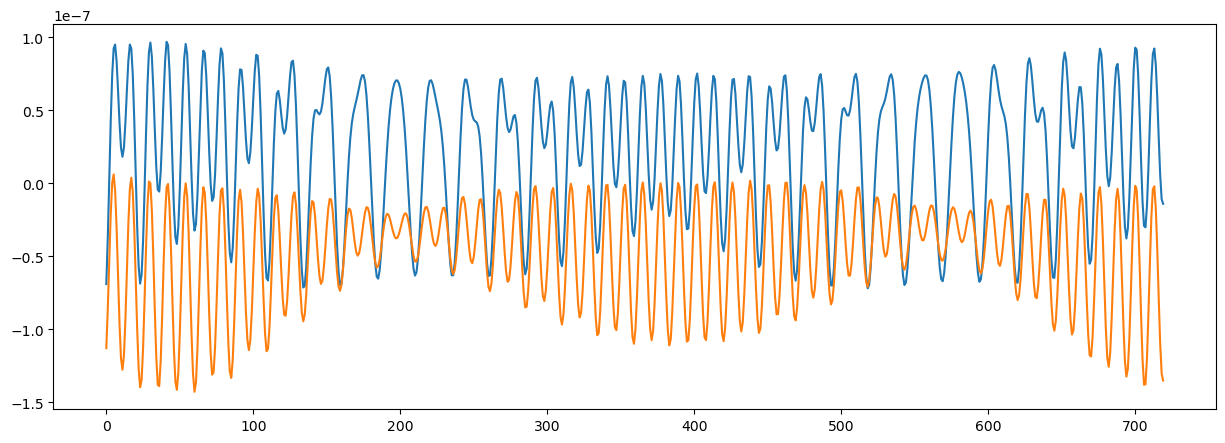

In [11]:
plt.figure(figsize=(15,5))
plt.plot(tideN2*1e-1)
plt.plot(tideN)

In [12]:
gtide = Stream()

gtideN = Trace()
gtideN.data = tideN
gtideN.stats.delta = 3600
gtideN.stats.starttime = config['tbeg']
gtideN.stats.station = "GTID"
gtideN.stats.channel = "LAN"
gtideN.stats.network = "BW"

gtideE = Trace()
gtideE.data = tideE
gtideE.stats.delta = 3600
gtideE.stats.starttime = config['tbeg']
gtideE.stats.station = "GTID"
gtideE.stats.channel = "LAE"
gtideE.stats.network = "BW"

gtide += gtideE
gtide += gtideN

In [13]:
tilts = Stream()

tilts += tromy0.merge(fill_value="interpolate").select(channel="*N")[0].copy()
tilts += tromy0.merge(fill_value="interpolate").select(channel="*E")[0].copy()

tilts += gtide.copy()

In [14]:
pmin, pmax = 25, 11

tilts = tilts.detrend("linear")
tilts = tilts.taper(0.05)
tilts = tilts.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=2, zerophase=True)
tilts = tilts.resample(1/3600)
tilts = tilts.trim(config['tbeg'], config['tend'], nearest_sample=True)
tilts


4 Trace(s) in Stream:
BW.ROMYT..MAN | 2024-03-08T23:59:59.934999Z - 2024-04-07T22:59:59.934999Z | 3600.0 s, 720 samples
BW.ROMYT..MAE | 2024-03-08T23:59:59.935000Z - 2024-04-07T22:59:59.935000Z | 3600.0 s, 720 samples
BW.GTID..LAE  | 2024-03-09T00:00:00.000000Z - 2024-04-07T23:00:00.000000Z | 3600.0 s, 720 samples
BW.GTID..LAN  | 2024-03-09T00:00:00.000000Z - 2024-04-07T23:00:00.000000Z | 3600.0 s, 720 samples

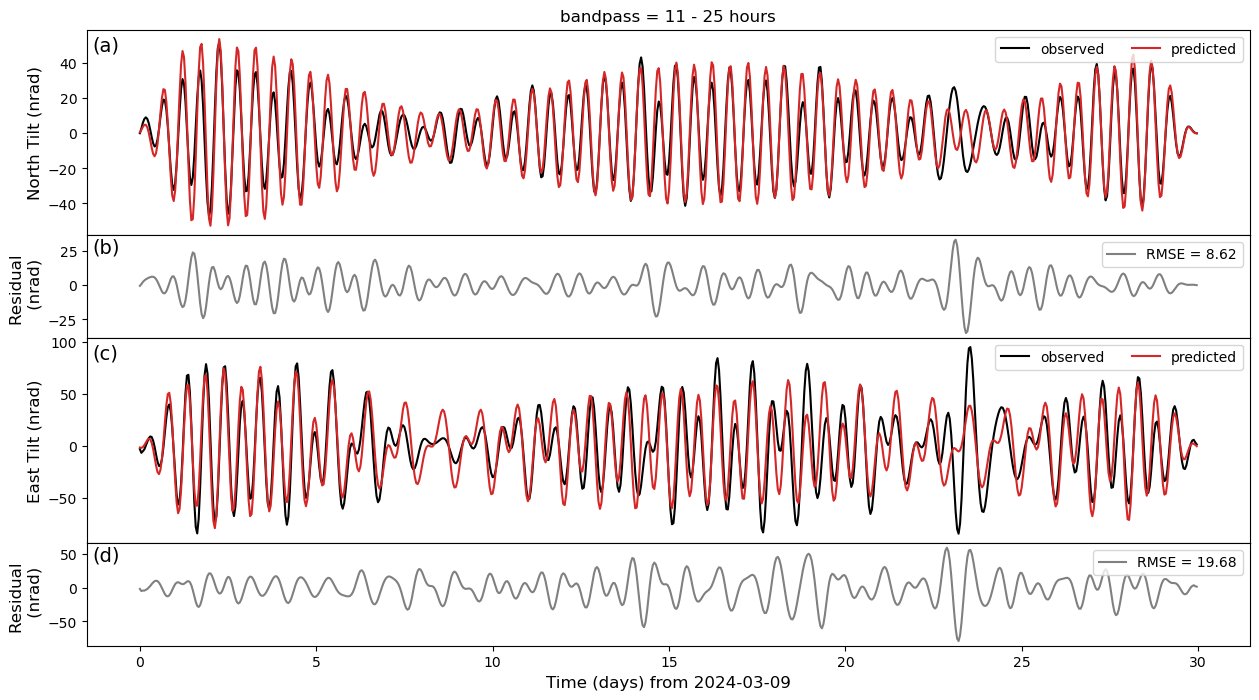

In [15]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)


    times = tilts.select(channel="*N")[0].times()/86400

    Ncol, Nrow = 1, 6

    font = 12

    tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])

    N1 = tilts.select(station="ROMYT", channel="*N")[0].data*tilt_scale
    N2 = tilts.select(station="GTID", channel="*N")[0].data*tilt_scale

    E1 = tilts.select(station="ROMYT", channel="*E")[0].data*tilt_scale
    E2 = tilts.select(station="GTID", channel="*E")[0].data*tilt_scale

    ax1.plot(times, N1, color="k", label="observed")
    ax1.plot(times, N2, color="tab:red", label="predicted")

    ax2.plot(times, (N1-N2), color="grey", label=f"RMSE = {__rmse(N1, N2)}")

    ax3.plot(times, E1, color="k", label="observed")
    ax3.plot(times, E2, color="tab:red", label="predicted")

    ax4.plot(times, (E1-E2), color="grey", label=f"RMSE = {__rmse(E1, E2)}")

    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"North Tilt ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot()

fig.savefig(config['path_to_figs']+f"SF_Tilt_predicted_tides.png", format="png", dpi=150, bbox_inches='tight')



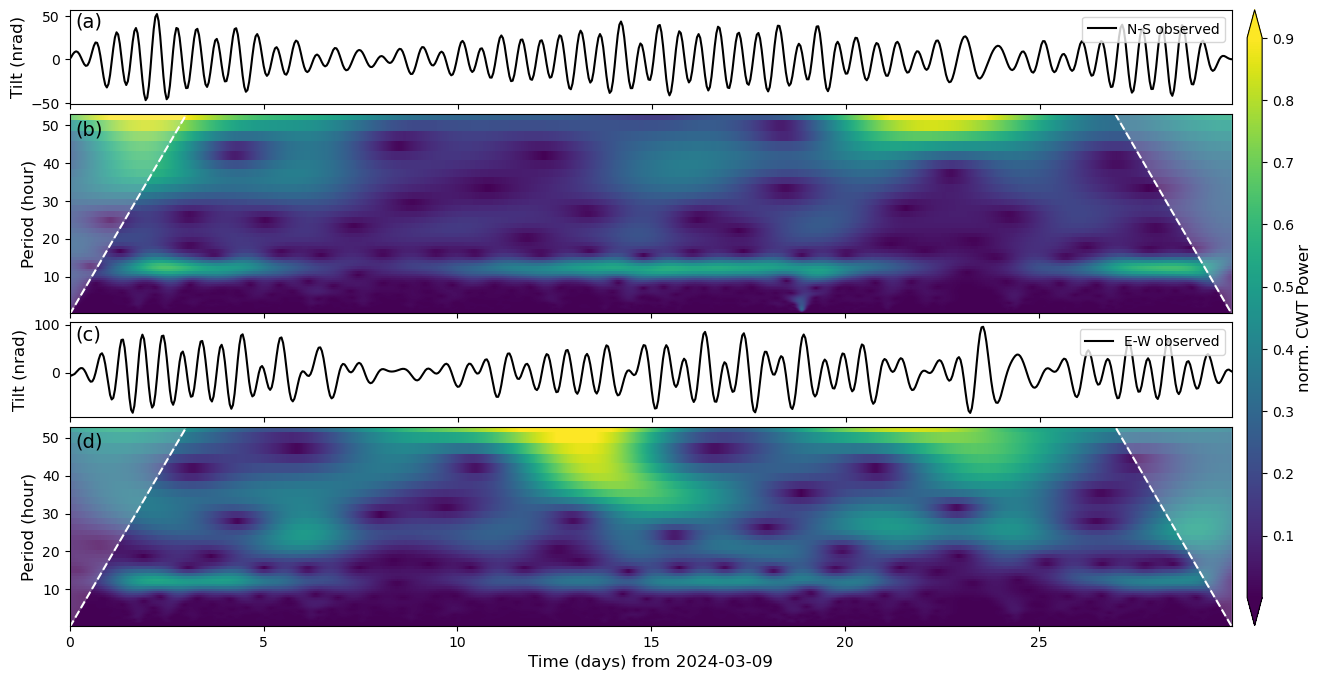

In [16]:
def __makeplot_cwt_all():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1/86400

    times = tilts.select(channel="*N")[0].times()*tscale

    Ncol, Nrow = 1, 6

    font = 12

    cmap = plt.get_cmap("viridis")

    tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])

    axes = [ax1, ax2, ax3, ax4]

    N1 = tilts.select(station="ROMYT", channel="*N")[0].data*tilt_scale
    E1 = tilts.select(station="ROMYT", channel="*E")[0].data*tilt_scale
    periodN = 1/outN['frequencies']/3600
    periodE = 1/outE['frequencies']/3600


    ax1.plot(times, N1, color="k", label="N-S observed")
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    im1 = ax2.pcolormesh(outN['times']*tscale*3600, periodN, outN['cwt_power'],
                         cmap=cmap,
                         vmin=np.nanmin(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*1.1),
                         vmax=np.nanmax(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*0.9),
                        )
    ax2.plot(outN['times']*tscale*3600, 1/outN['cone']/3600, color="white", ls="--")
    ax2.fill_between(outN['times']*tscale*3600, 1/outN['cone']/3600, max(periodN)*np.ones(len(outN['cone'])), color="white", alpha=0.2)
    ax2.set_ylim(min(periodN), max(periodN))
    ax2.set_xticklabels([])

    ax3.plot(times, E1, color="k", label="E-W observed")
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    im2 = ax4.pcolormesh(outE['times']*tscale*3600, periodE, outE['cwt_power'],
                         cmap=cmap,
                         vmin=np.nanmin(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*1.1),
                         vmax=np.nanmax(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*0.9),
                        )
    ax4.plot(outE['times']*tscale*3600, 1/outE['cone']/3600, color="white", ls="--")
    ax4.fill_between(outE['times']*tscale*3600, 1/outE['cone']/3600, max(periodE)*np.ones(len(outE['cone'])), color="white", alpha=0.2)
    ax4.set_ylim(min(periodE), max(periodE))


    ax1.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Period (hour)", fontsize=font)
    ax3.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Period (hour)", fontsize=font)
    ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")
    cb.set_label("norm. CWT Power", fontsize=font, labelpad=2, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all()

fig.savefig(config['path_to_figs']+f"SF_Tilt_cwt.png", format="png", dpi=150, bbox_inches='tight')


In [17]:
# fig, ax = plt.subplots(2, 1)

# tromy = tromy0.copy()
# tromy.detrend("linear")
# tromy.taper(0.05)
# tromy.filter("bandpass", freqmin=1/(25*3600), freqmax=1/(11*3600), corners=4, zerophase=True)

# Ntilt = tromy.select(channel="*N")[0].data
# Etilt = tromy.select(channel="*E")[0].data

# ax[0].plot(times, __reduce(tideN, 100))
# ax[0].plot(tromy0.select(channel="*N")[0].times()/3600, Ntilt)

# ax[1].plot(times,  __reduce(tideE, 100))
# ax[1].plot(tromy0.select(channel="*E")[0].times()/3600, Etilt)


### Apply Correction

In [18]:
# ## correction for temperature trends based on MAT
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")

# # from functions.correct_temperature_trend import __correct_temperature_trend

# tromy_mod = __correct_temperature_trend(tromy, temperature_correction['TROMY'], n_shift=0, intercept=False)

# tromy_mod.plot(equal_scale=False);